In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    # dict(name="noneut", id="sc9a-ions_electrons_only", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_cvode", id="sc9ab-no_ei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_beuler", id="sc9abx2-no_ei_beuler", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_512", id="sc10-no_ei_512cells", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_512_eiswap", id="sc10b-swap_ei_ee", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="fix_ee", id="sc10b-fix_ee_braginskii", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="swap_ee_ei", id="sc10c-swap_ee_ei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="fix_sqrt2", id="sc10d-fix_ee_kappa_sqrt2", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="no_neutrals", id="sc10e-no_neutrals", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="no_outflow", id="sc10f-also_no_outflow", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="no_outflow_fix", id="sc10g-fix_nooutflow_bc", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="no_outflow_fix_minmod", id="sc10gb-fix_nooutflow_bc_MinMod", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="no_outflow_fix_minmod_fixboundary", id="sc10gc-fix_nooutflow_bc_MinMod_fixboundary", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="parsheath_fix", id="sc12a-parsheath_fixes", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="add_visc_heat", id="sc12ab-add_visc_heat", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    dict(name="add_bndry_fix", id="sc12ac-add_bndry_flux_fix", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    
    # dict(name="gamma_3.5", id="sc12ad-gamma_i_3.5", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 

]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])
    cs[case["name"]].ds.load()


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


In [5]:
cs["add_bndry_fix"].ds["NVd+"].isel(t=-1, pos = slice(-5, None)).values

array([ 7.57801706e-06,  2.80170723e-05,  3.50698172e-05, -3.50698172e-05,
        0.00000000e+00])

## ReMKiT1D

### Read wrapper pickle file to know what model is being run
- This is required to know how to read the HDF5 files

In [53]:
type(wrapper)

RMK_support.rk_wrapper.RKWrapper

In [3]:
from RMK_support import RKWrapper
import RMK_support.simple_containers as sc
import RMK_support.IO_support as io
import RMK_support.dashboard_support as ds
import pickle

hdf5Filepath = "/ssd_scratch/compare_data/RMK_hermes3-sc12ac-add_bndry_flux_fix-no-kin/RMK_hermes3-add_bndry_flux_fix" 
wrapperPickleFilename = "/ssd_scratch/compare_data/RMK_hermes3-sc12ac-add_bndry_flux_fix-no-kin/RMK_hermes3-sc12ac-add_bndry_flux_fix-no-kin.pkl" # Replace with the name of the pkl file containing your wrapper

wrapper = pickle.load(open(wrapperPickleFilename,"rb"))
# assert type(wrapper) == RKWrapper
varsNotInOutput=list(wrapper.varCont.dataset.keys()-set(wrapper.varsInOutput()))

In [3]:
wrapper.optionsPETSc

{'active': True,
 'solverOptions': {'solverToleranceRel': 1e-17,
  'solverToleranceAbs': 1e-20,
  'solverToleranceDiv': 10000000.0,
  'maxSolverIters': 10000,
  'kspSolverType': 'gmres',
  'hyprePCType': '',
  'PETScCommandLineOpts': '-pc_type bjacobi -sub_pc_type ilu -sub_pc_factor_shift_type nonzero -sub_pc_factor_levels 1 -ksp_gmres_restart 30 -ksp_gmres_preallocate -sub_ksp_type preonly -sub_pc_factor_diagonal_fill'},
 'objGroups': 1}

### Load files with the wrapper

In [7]:
numFiles = 8 # file 0 is the initial condition, so count from 1!
loadFilenames = [os.path.join(hdf5Filepath, f'ReMKiT1DVarOutput_{i}.h5') for i in range(numFiles)]
loadedData = io.loadFromHDF5(wrapper.varCont,filepaths=loadFilenames,varsToIgnore=varsNotInOutput,isXinMeters=wrapper.grid.isLengthInMeters)
ld = loadedData

#There is no automatic unnormalisation, but you can get them here
import RMK_support.sk_normalization as skn
norms = wrapper.normalization
n = skn.calculateNorms(norms["eVTemperature"], norms["density"], norms["referenceIonZ"])
n = {**norms, **n}

# Manually normalise some of the key variables

ld["Te"] *= n["eVTemperature"]
ld["Ti"] *= n["eVTemperature"]
ld["Te_dual"] *= n["eVTemperature"]
ld["Ti_dual"] *= n["eVTemperature"]
ld["ne"] *= n["density"]
ld["Wi"] *= n["eVTemperature"]*n["density"] * constants("q_e")
ld["We"] *= n["eVTemperature"]*n["density"] * constants("q_e")
ld["Ge"] *= n["density"] * n["speed"]
ld["Gi"] *= n["density"] * n["speed"]
ld["qi"] *= n["heatFlux"] * 1e-6    # Conductive flux [MW/m2]
ld["qe"] *= n["heatFlux"] * 1e-6    # Conductive flux [MW/m2]

ld["Ne"] = ld["ne"]
ld["Td+"] = ld["Ti"]
ld["Te"] = ld["Te"]
ld["Vd+"] = ld["ui"]

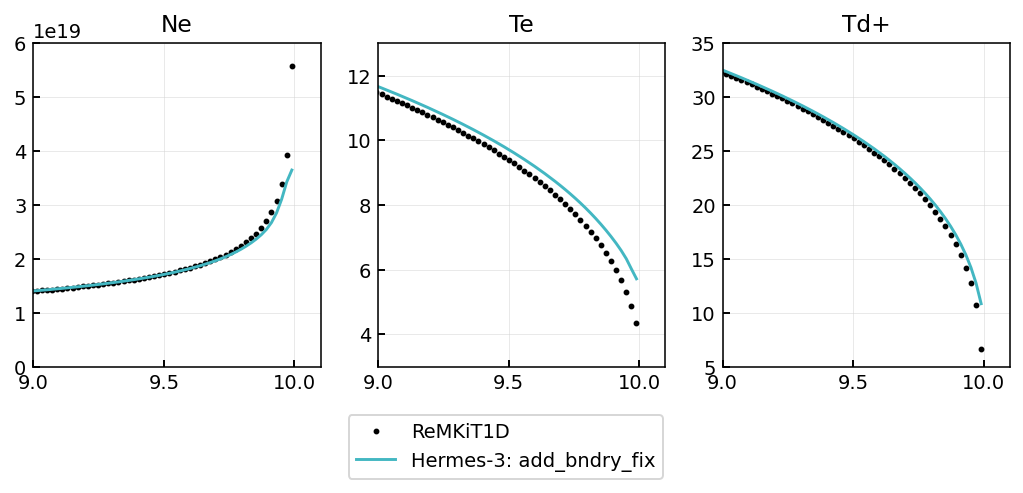

In [9]:
fig, axes = plt.subplots(1,3, figsize = (9,3))

rk = ld.isel(time=-1)

ranges = {"Ne" : (1, 6e19), "Te" : (3, 13), "Td+" : (5, 35)}
# ranges = {"Ne" : (None, None), "Te" : (None, None), "Td+" : (None, None)}

for i, param in enumerate(["Ne", "Te", "Td+"]):

    ax = axes[i]
    ax.plot(rk["x"], rk[param], label = "ReMKiT1D" if i == 0 else "", lw = 0, marker = "o", ms = 2, c = "k")
    
    for case in cs:
        ds = cs[case].ds.isel(t=-1, pos = slice(2,-2))
        ax.plot(ds["pos"], ds[param], label=f"Hermes-3: {case}" if i == 0 else "")

        
    ax.set_title(param)
    ax.set_xlim(9,10.1)
    ax.set_ylim(ranges[param])
    
fig.legend(loc = "upper center", ncol = 1, bbox_to_anchor=(0.5,0))

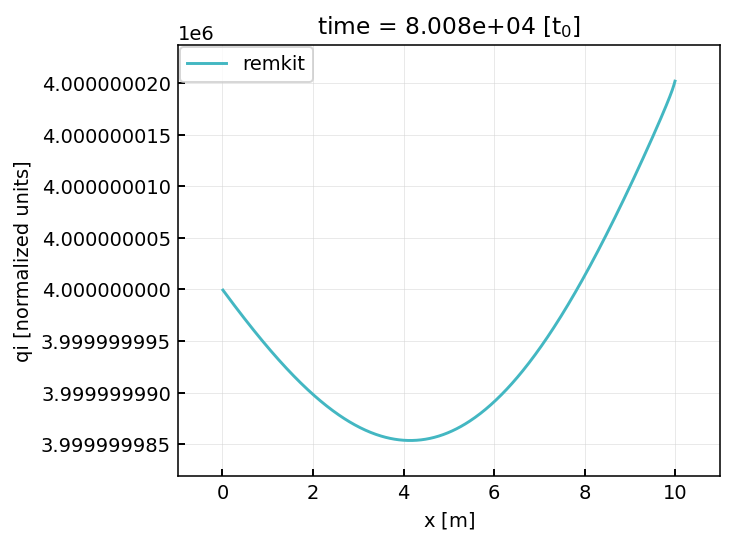

In [81]:
fig, ax = plt.subplots()
(ld["qi"]).isel(time=-1).plot(ax = ax, label = "remkit")
# ds["Te"].isel(t=-1, pos = slice(2,-2)).plot(ax=ax, label = "hermes")
ax.legend()
# ax.invert_xaxis()
# ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
# ax.set_xscale("log")


In [22]:
wrapper.getTermsThatEvolveVar("We")

[('heating_ei_', 'e'),
 ('bohmBoundary_e_', 'energy_BCGamma'),
 ('bohmBoundary_e_', 'energy_BCKin'),
 ('fluidBase_e_', 'energy_wAdv'),
 ('fluidBase_e_', 'energy_pAdv'),
 ('fluidBase_e_', 'energy_lorentzWork'),
 ('fluidBase_e_', 'energy_divq')]

In [15]:
cs.keys()

dict_keys(['no_neutrals', 'no_outflow_fix'])

# Profiles

# Convergence

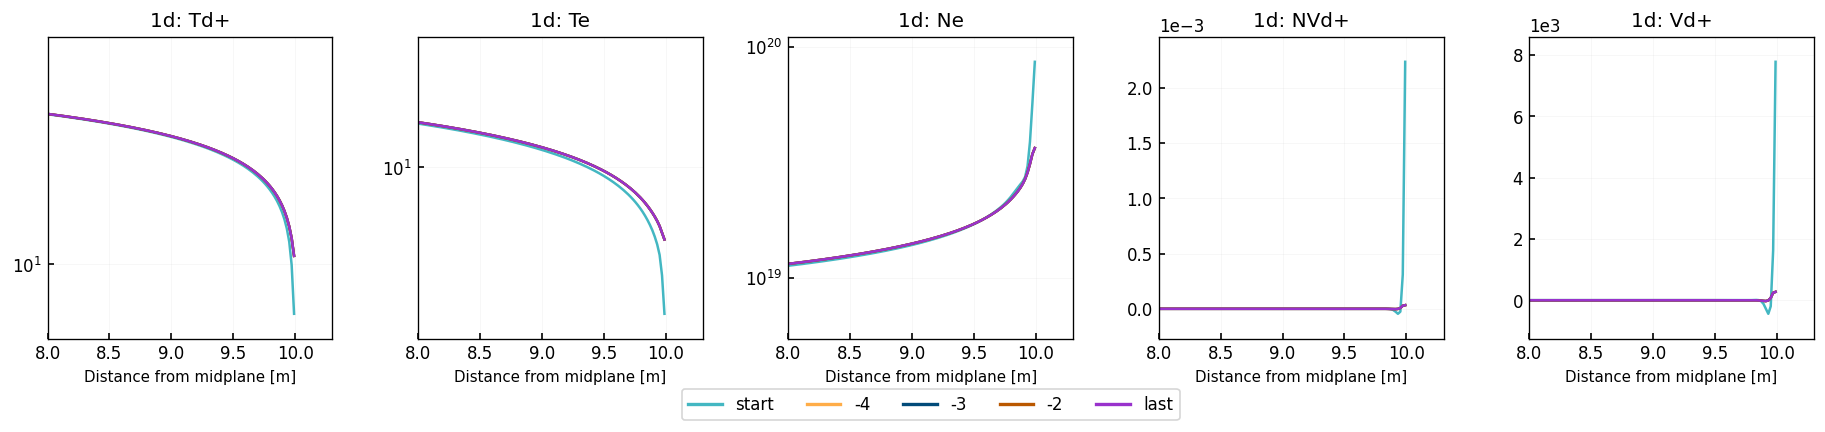

In [6]:
case = "no_outflow_fix"

lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Ne", "NVd+", "Vd+"],
    regions = ["1d"],
    lw = 1.5,
    markersize = 0,
    xlims=(8,10.3)
)

# Profile comparison

GUARD REPLACEMENT IS WRONG - FIX ME


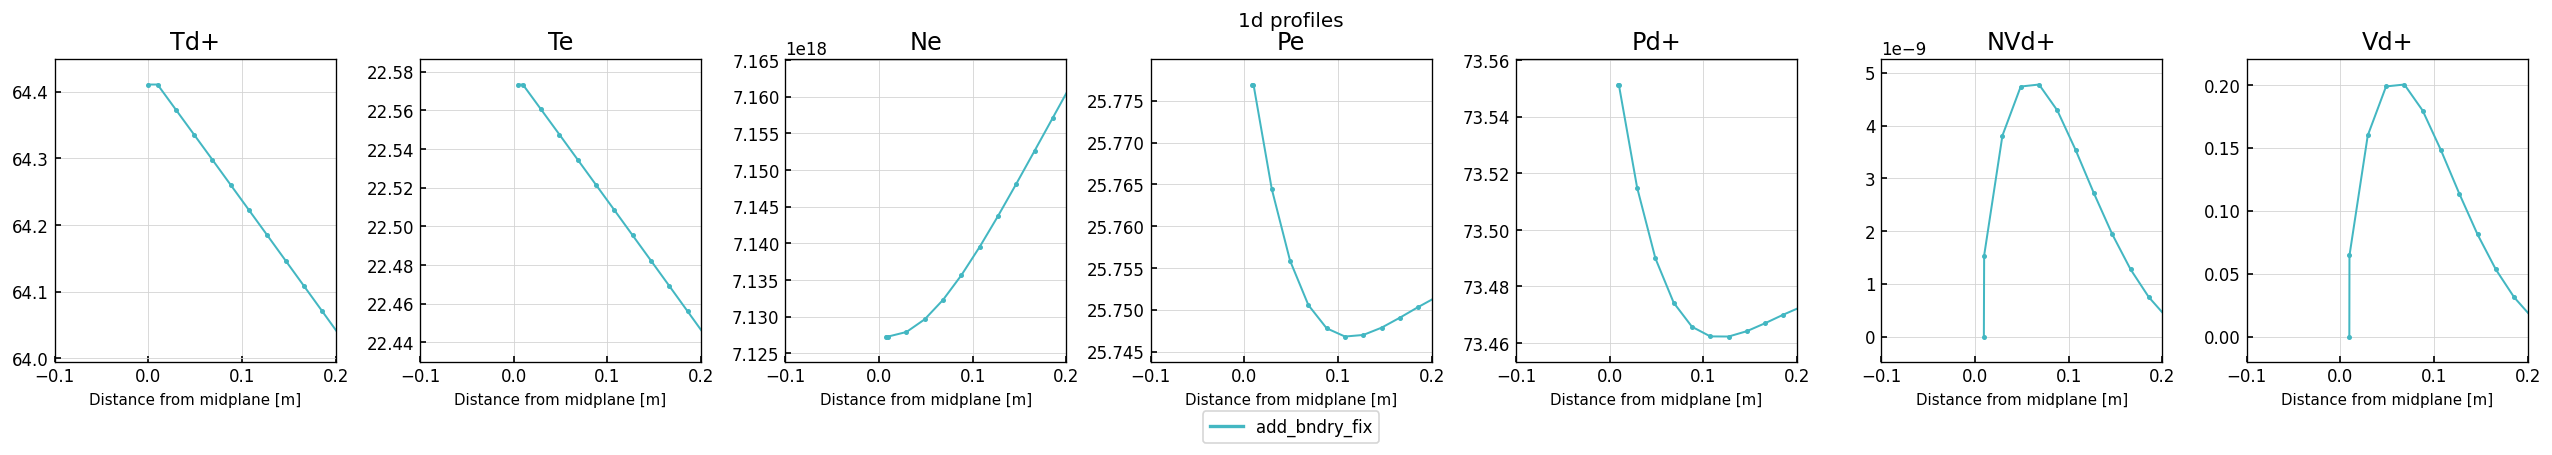

In [16]:
toplot = {}
for name in cs:
    ds = cs[name].ds
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    toplot[name] = ds

lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "NVd+", "Vd+"],
    # params = ["SPd+_nvh", "SPe_nvh"],
    regions = ["1d"],
    lw = 1.2,
    # xlims=(9.7,10.02)
    xlims=(-0.1,0.2)
)

In [46]:
cs.keys()

dict_keys(['no_outflow_fix', 'parsheath_fix', 'add_visc_heat', 'add_bndry_fix'])

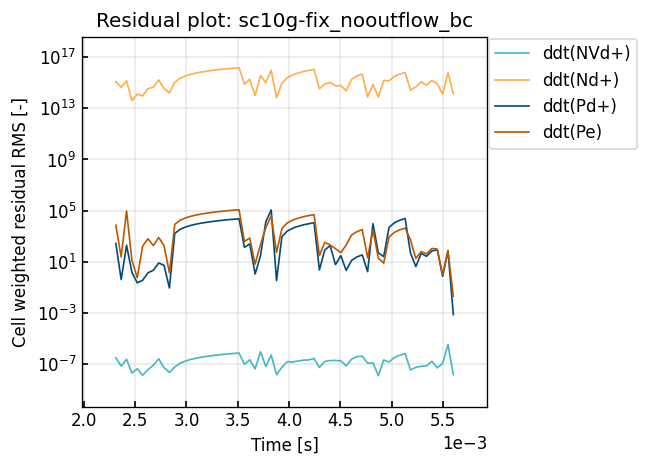

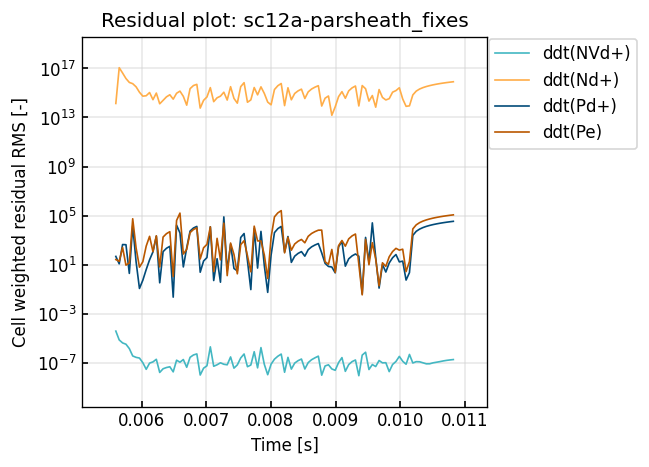

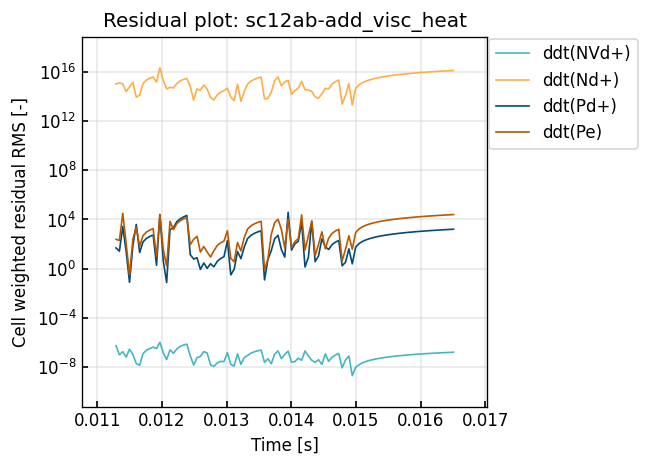

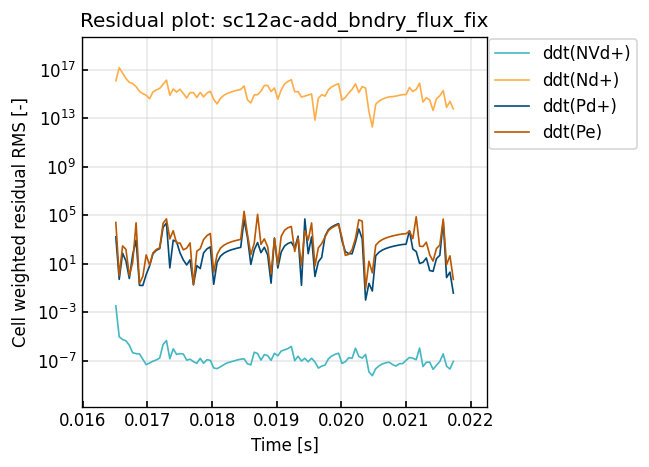

In [48]:
for case in cs:
    plot_ddt(cs[case])

# Fluxes

In [5]:
ds = cs["no_outflow_fix_minmod"].ds.isel(t=-1, pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 5/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

# hfe_cond2 = scipy.integrate.cumulative_trapezoid(ds["ConductionDiv_e_par"], ds["pos"], initial = 0) * ds["da"] * -1e-6 
hfi_cond = (ds["ConductionDiv_d+_par"] * ds["dv"]).cumsum("pos") * -1e-6 * 3/2
hfe_cond = (ds["ConductionDiv_e_par"] * ds["dv"]).cumsum("pos") * -1e-6 * 3/2

fig, ax = plt.subplots()
ax.plot(ds["pos"], hfe_cond, label = "electron conduction")
ax.plot(ds["pos"], hfi_cond, label = "ion conduction")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")
# ax.set_ylim(-5, ax.get_ylim()[1])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(9.8,10.0)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW")

KeyError: 'ConductionDiv_d+_par'

## hermes

Text(0, 0.5, 'MW')

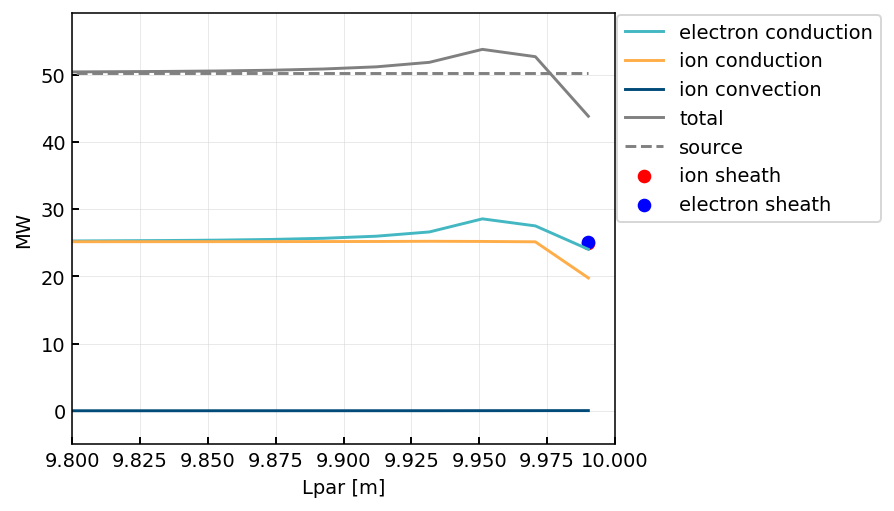

In [132]:
ds = cs["no_outflow_fix_minmod"].ds.isel(t=-1, pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

fig, ax = plt.subplots()
ax.plot(ds["pos"], hfe_cond, label = "electron conduction")
ax.plot(ds["pos"], hfi_cond, label = "ion conduction")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")
ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")



ax.scatter([ds["pos"][-1].data], [hfi_sheath[-1].data*-1], c = "red", label = "ion sheath")
ax.scatter([ds["pos"][-1].data], [hfe_sheath[-1].data*-1], c = "blue", label = "electron sheath")

ax.set_ylim(-5, ax.get_ylim()[1])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
ax.set_xlim(9.8,10.0)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW")

In [116]:
ds = self.ds
qe = self.qe
Zi = self.Zi
Mi = self.Mi
Me = self.Me
Ge = self.Ge
sheath_ion_polytropic = self.sheath_ion_polytropic
phi_wall = self.phi_wall

dasheath = self.get_target_value(ds["da"])
dv = ds.isel(pos=-3)["dv"].values

visheath = self.get_target_value(ds["Vd+"])
vesheath = self.get_target_value(ds["Ve"])

nesheath = self.get_target_value(ds["Ne"])
nisheath = self.get_target_value(ds["Nd+"])

tesheath = self.get_target_value(ds["Te"])
tisheath = self.get_target_value(ds["Td+"])

cssheath = np.sqrt((sheath_ion_polytropic * tisheath*qe + Zi * tesheath*qe) / Mi)   # [m/s] Bohm criterion sound speed

ion_sum = Zi * nisheath * cssheath   # Sheath current
phisheath = tesheath * np.log(np.sqrt(tesheath / (Me * 2*np.pi)) * (1 - Ge) * nesheath / ion_sum)   # [V] sheath potential, (note Neumann BC)
vesheath = np.sqrt(tesheath / (2*np.pi * Me)) * (1 - Ge) * np.exp(-(phisheath - phi_wall)/tesheath)

pfi_sheath = -1 * cssheath * nisheath * dasheath   # [s^-1] ion particle flux into domain 
pfe_sheath = -1 * vesheath * nesheath * dasheath   # [s^-1] electron particle flux into domain 

# hfi_sheath = pfi_sheath * (self.gamma_i * tisheath*qe + 0.5*Mi*cssheath**2) * 1e-6   # [MW] electron heat flux into domain
# hfe_sheath = pfe_sheath * (self.gamma_e * tesheath*qe + 0.5*Me*vesheath**2) * 1e-6   # [MW] electron heat flux into domain

hfi_sheath = pfi_sheath * self.gamma_i * tisheath*qe * 1e-6   # [MW] electron heat flux into domain
hfe_sheath = pfe_sheath * self.gamma_e * tesheath*qe * 1e-6   # [MW] electron heat flux into domain

print(f"hfi_sheath = {hfi_sheath[-1]:.3f}")
print(f"hfe_sheath = {hfe_sheath[-1]:.3f}")

hfi_sheath = -25.012
hfe_sheath = -25.074


## Remkit comparison - flux as diagnostic variable

Text(0, 0.5, 'MW / m2')

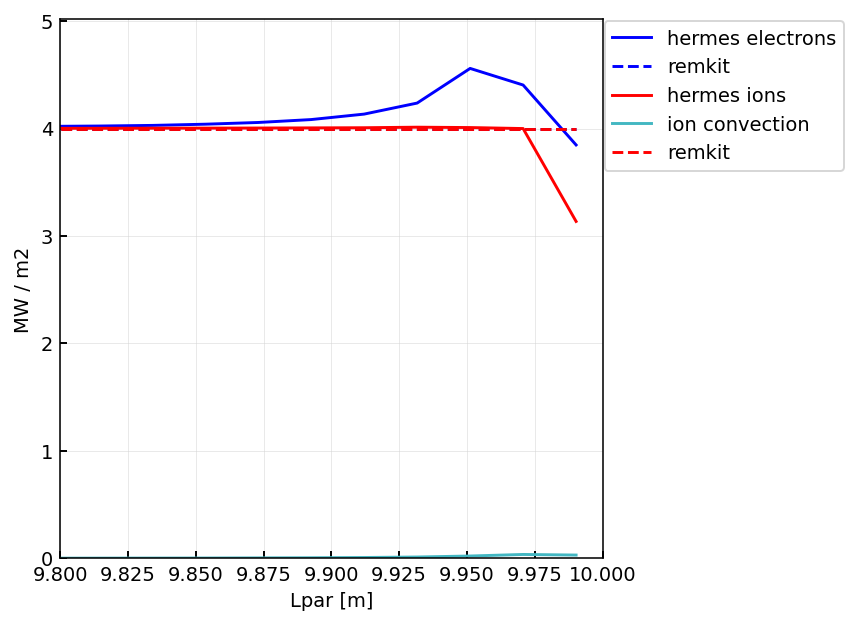

In [101]:
ds = cs["no_outflow_fix_minmod_fixboundary"].ds.isel(t=-1,  pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(ds["pos"], hfe_cond, c = "blue", label = "hermes electrons")
ax.plot(ld["x"], ld["qe"].isel(time=-1), c = "blue", ls = "--", label = "remkit")
ax.plot(ds["pos"], hfi_cond, c = "red", label = "hermes ions")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
# ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")

ax.plot(ld["x"], ld["qi"].isel(time=-1), c = "red", ls = "--", label = "remkit")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")

ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
ax.set_xlim(9.8,10.0)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW / m2")

## Remkit comparison - flux calculated from grad(T)

In [143]:
rk_kappa_e.shape

(512, 512)

Text(0, 0.5, 'MW / m2')

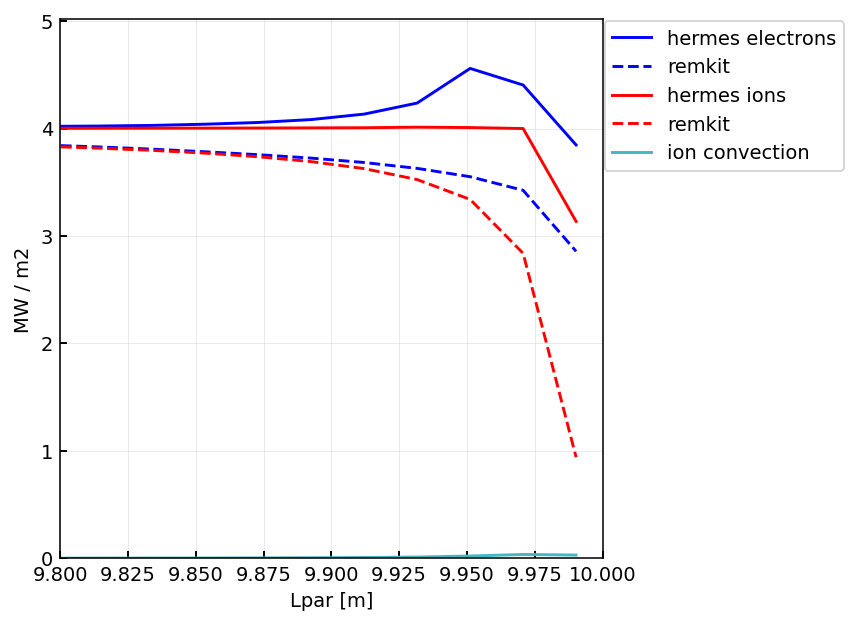

In [149]:
if "time" in ld.dims:
    ld = ld.isel(time=-1)

ds = cs["no_outflow_fix_minmod_fixboundary"].ds.isel(t=-1,  pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

rk_kappa_e = ds["kappa_par_e"].data * ld["Te_dual"].data**(5/2) / ds["Te"].data**(5/2)
rk_kappa_i = ds["kappa_par_d+"].data * ld["Ti_dual"].data**(5/2) / ds["Td+"].data**(5/2)

hfe_cond_rk = rk_kappa_e * np.gradient(ld["Te"], ld["x"]) * -1e-6 
hfi_cond_rk = rk_kappa_i * np.gradient(ld["Ti"], ld["x"]) * -1e-6 

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(ds["pos"], hfe_cond, c = "blue", label = "hermes electrons")
ax.plot(ld["x"], hfe_cond_rk, c = "blue", ls = "--", label = "remkit")

ax.plot(ds["pos"], hfi_cond, c = "red", label = "hermes ions")
ax.plot(ld["x"], hfi_cond_rk, c = "red", ls = "--", label = "remkit")

ax.plot(ds["pos"], hfi_conv, label = "ion convection")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")

ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
ax.set_xlim(9.8,10.0)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW / m2")

In [ ]:
ds = cs["no_outflow_conddiags"].ds.isel(t=-1, pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 5/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

# hfe_cond2 = scipy.integrate.cumulative_trapezoid(ds["ConductionDiv_e_par"], ds["pos"], initial = 0) * ds["da"] * -1e-6 
hfi_cond = (ds["ConductionDiv_d+_par"] * ds["dv"]).cumsum("pos") * -1e-6 * 3/2
hfe_cond = (ds["ConductionDiv_e_par"] * ds["dv"]).cumsum("pos") * -1e-6 * 3/2

fig, ax = plt.subplots()
ax.plot(ds["pos"], hfe_cond, label = "electron conduction")
ax.plot(ds["pos"], hfi_cond, label = "ion conduction")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")
# ax.set_ylim(-5, ax.get_ylim()[1])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(9.8,10.0)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW")

# Export

In [43]:
cs.keys()

dict_keys(['no_outflow_fix', 'parsheath_fix', 'add_visc_heat', 'add_bndry_fix'])

In [44]:
ds = cs['add_bndry_fix'].ds.isel(pos = slice(2,-2), t = -1)

df = pd.DataFrame()
df.index = ds["pos"].values
df.index.name = "y"

for param in ["Ne", "Nd", "Pe", "Pd+", "Pe", "Te", "Td+", "Td"]:
    if param in ds:
        df[param] = ds[param].values
    else:
        df[param] = np.nan


df["NVd+"] = ds["NVd+"] / (constants("mass_p")*2)

if "NVd" in ds:
    df["NVd"] = ds["NVd"] / (constants("mass_p")*2)
else:
    df["NVd"] = np.nan

df.to_csv(r"/ssd_scratch/hcases/selcoll/sc12ac-add_bndry_flux_fix.csv")

